# Experiment 2

**Hypothesis**: Binning-based techniques (Isotonic Regression and Histogram Binning) generally work better than scaling-based ones (Platt Scaling and Beta Calibration) when large datasets are available.

During the experiment 1, we observed that binning-based calibration (Isotonic and Histogram) performs better in general. We also noticed that binning-based methods dominated in FB13k, WN11 and YAGO39, which has more data than the rest. Previous work also suggested that binning-based methods tend to overfit, especially on smaller datasets . Thus, to evaluate hypothesis (2), we took these 3 datasets, and gradually shrink the size of the calibration sets by randomly sampling $k\%$ of them, and compare the number of wins in terms of BS, NLL, and ECE between binning-based and scaling-based methods.

In [17]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [18]:
import random
from typing import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [19]:
from probcalkge import Experiment, DatasetWrapper, ExperimentResult
from probcalkge import get_datasets, get_calibrators, get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, accuracy
from probcalkge.calmodels2 import get_calibrators

In [20]:
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [21]:
def dataset_stats(ds: Iterable[DatasetWrapper]) -> pd.DataFrame:
    vals = []
    rows = []
    cols = ['train', 'valid', 'test', 'entities', 'relations']
    for i in ds:
        rows.append(i.name)
        vals.append(i.stats)
    return pd.DataFrame(vals, index=rows, columns=cols)

In [22]:
df = dataset_stats(ds)
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   train &   valid &    test &  entities &  relations \\
\midrule
FB13k      &  316232 &   11816 &   47464 &     75043 &         13 \\
WN11       &  110361 &    4877 &   19706 &     38194 &         11 \\
YAGO39     &  354994 &   18471 &   18507 &     37612 &         37 \\
DBpedia50  &   32388 &     246 &    4196 &     24624 &        351 \\
UMLS       &    5216 &    1304 &    1322 &       135 &         46 \\
Kinship    &    8544 &    2136 &    2148 &       104 &         25 \\
Nations    &    1592 &     398 &     402 &        14 &         55 \\
YAGO\_ET    &  364810 &   50194 &   49268 &     26957 &         64 \\
DBpedia\_ET &  653188 &  104776 &  104900 &     99240 &        316 \\
\bottomrule
\end{tabular}



In [23]:
def shrink_valid(ds: DatasetWrapper, perc=0.5) -> DatasetWrapper:
    valids = np.hstack([ds.X_valid, ds.y_valid.reshape([-1, 1])])
    new_valids = np.array(random.sample(valids.tolist(), int(perc * len(valids))))
    return DatasetWrapper(f'{ds.name}',
                            ds.X_train,
                            new_valids[:, :3], new_valids[:, 3].astype(int),
                            ds.X_test, ds.y_test
    )


In [24]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ece]
)

In [25]:
# exp.train_kges()

exp.load_trained_kges('../saved_models/trained_kges')

exp_reses = []

scales = np.array([1.0, 0.7, 0.4, 0.1, 0.05, 0.01])

for i in scales:
    new_fb = shrink_valid(ds.fb13, perc=i)
    new_wn = shrink_valid(ds.wn18, perc=i)
    new_yg = shrink_valid(ds.yago39, perc=i) 
    
    exp.datasets = [new_fb, new_wn, new_yg]
    
    exp_res = exp.run_with_trained_kges()
    exp_reses.append(exp_res)


Loaded trained KG embedding models.
training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
trainin

In [26]:
def res_pivot(exp_res: ExperimentResult) -> pd.DataFrame:
    newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])
    newdf['avg_excl_uncal'] = newdf.loc[:, newdf.columns != 'UncalCalibrator'].mean(axis=1)
    return newdf

In [27]:
lst_counts = []
for res in exp_reses:
    counts = res_pivot(res).xs('negative_log_loss', axis=0, level=2, drop_level=False).idxmin(axis=1).value_counts()
    lst_counts.append(counts)
various_counts = pd.DataFrame(lst_counts,  columns=counts.index, index=scales.astype(str))
various_counts['UncalCalibrator'] = pd.Series([0]*len(scales), index=scales.astype(str))
lgds = ['UncalCalibrator', 'PlattCalibrator', 'IsotonicCalibrator', 
        'BetaCalibrator', 'HistogramBinningCalibrator', ]
various_counts = various_counts.reindex(columns=lgds).fillna(0)

In [28]:
plt.rcParams['figure.dpi'] = 100 # default for me was 75
plt.rc('figure', titlesize=10)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=7)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=2)

<AxesSubplot:>

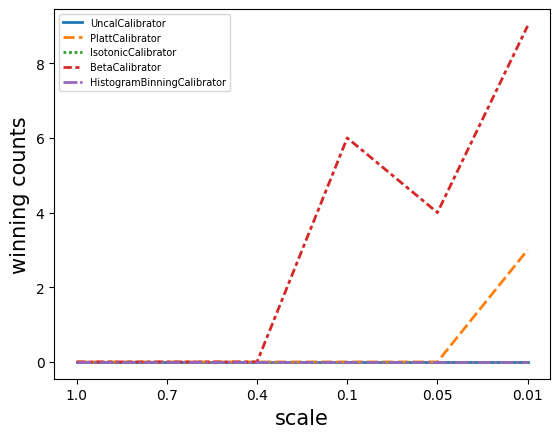

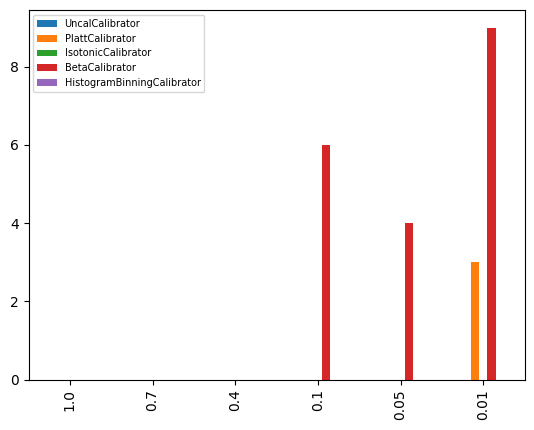

In [29]:
import seaborn as sns
ax = sns.lineplot(data=various_counts, sort=False)
ax.set(xlabel='scale', ylabel='winning counts')